In [1]:
from Bio.Seq import Seq
from Bio import motifs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import main.functions as fnc
from maxentpy.maxent import load_matrix5, load_matrix3, score5, score3

In [2]:
annotationFile = "./ref/Homo_sapiens.GRCh38.112.chr.gtf.gz"
genomeFile = "./data/Homo_sapiens.GRCh38.dna_sm.primary_assembly.fa.gz"

In [3]:
# use old code to get splice site sequences
transcriptExons = fnc.getExonData(annotationFile)

genome = fnc.openGenomeFile(genomeFile)

fivePrimeSites, threePrimeSites = fnc.getSpliceSites(transcriptExons, genome)

fivePrimeSequences = fnc.extractSequences(fivePrimeSites, genome)
threePrimeSequences = fnc.extractSequences(threePrimeSites, genome)

In [12]:
matrix5 = load_matrix5()
matrix3 = load_matrix3()

spliceSiteStrengths = {"Five Prime Strengths": [], "Three Prime Strengths": []}

# add each strength to the dictionary
for seq5 in fivePrimeSequences:
    fivePrimeStrength = score5(seq5, matrix5)
    spliceSiteStrengths["Five Prime Strengths"].append(fivePrimeStrength)

for seq3 in threePrimeSequences:
    if "N" in seq3:
        continue
    threePrimeStrength = score3(seq3, matrix3)
    spliceSiteStrengths["Three Prime Strengths"].append(threePrimeStrength)

spliceSiteStrengths["Five Prime Strengths"] = np.array(spliceSiteStrengths["Five Prime Strengths"])
spliceSiteStrengths["Three Prime Strengths"] = np.array(spliceSiteStrengths["Three Prime Strengths"])


NNNNNNNNNNNNNNNNNNNGAAT
245010


In [8]:
# create position specific scoring matrices (PSSM) given splice site sequences
# gives log odds scores for each nucleotide in each position
# not sure if this is correctly done though...
def createPSSM(sequences):
    instances = []
    for seq in sequences:
        instances.append(Seq(seq)) # make everything into Seq objects for biopython motifs
    motif = motifs.create(instances)

    # Calculate total counts at each position
    totalCounts = np.zeros(motif.length)
    for i in range(motif.length):
        positionSum = 0
        for nt in 'ACGT': # at each position in the motif go through each nucleotide and add up all counts at said position
            positionSum += motif.counts[nt][i] 
        totalCounts[i] = positionSum # append the summed count at position "i" in the motif to the list of total counts

    # calculate log odds scores for PSSM
    PSSM = np.zeros((motif.length, 4))
    for i, nt in enumerate('ACGT'): # "i" will go from 0-3 representing columns with each nucleotide "ACGT"
        for j in range(motif.length): # "j" will go from 0-8 or 0-22 depending on 5' or 3' and represents the row or position in the sequence
            count = motif.counts[nt][j] # get the count of nucleotide "nt" at position "j"
            PSSM[j, i] = np.log2((count / totalCounts[j]) / 0.25) # at coordinate (j, i) in the matrix add the log odds score of that nucleotide at that position (formula for log odds found online)

    return PSSM

pssm5 = createPSSM(fivePrimeSequences)
pssm3 = createPSSM(threePrimeSequences)

print("PSSM for 5\' sites:")
print(pssm5)
print()
print("PSSM for 3\' sites:")
print(pssm3)

PSSM for 5' sites:
[[ 0.40503481  0.48636993 -0.40239069 -0.9479732 ]
 [ 1.33501376 -1.24900249 -1.03305447 -0.81652573]
 [-1.30067556 -3.14204604  1.67058399 -1.74976355]
 [-5.79894268 -6.95906712  1.98678572 -6.57737688]
 [-6.3330305  -3.74555387 -6.37905067  1.9638537 ]
 [ 1.22949227 -2.70999359  0.42204621 -2.62150401]
 [ 1.40795787 -1.59651815 -0.91408825 -1.04384224]
 [-1.36926522 -1.93769073  1.5878402  -1.53162422]
 [-0.46565632 -0.69591044 -0.38059756  0.91870637]]

PSSM for 3' sites:
[[-0.27845234  0.09067203 -0.42956374  0.45225027]
 [-0.38517882  0.12764923 -0.42295774  0.48120591]
 [-0.49136531  0.15236854 -0.46237164  0.53750845]
 [-0.59373244  0.16213894 -0.49550986  0.59370542]
 [-0.67709568  0.18587569 -0.5114237   0.61874603]
 [-0.76037785  0.20333006 -0.55227538  0.6565986 ]
 [-0.8113301   0.18652959 -0.59076767  0.70321711]
 [-0.91410083  0.18763422 -0.62283675  0.74935244]
 [-0.97984385  0.2030647  -0.69561998  0.78607803]
 [-1.03544866  0.12323278 -0.73931584  0.8

In [5]:
# add up log odds scores based on PSSM and return a strength for the splice site
def getSpliceSiteStrength(seq, PSSM):
    strength = 0
    for pos, base in enumerate(seq):
        if base == 'A':
            strength += PSSM[pos][0]
        elif base == 'C':
            strength += PSSM[pos][1]
        elif base == 'G':
            strength += PSSM[pos][2]
        elif base == 'T':
            strength += PSSM[pos][3]
    return strength

In [8]:
spliceSiteStrengths = {"Five Prime Strengths": [], "Three Prime Strengths": []}

# add each strength to the dictionary
for seq5 in fivePrimeSequences:
    fivePrimeStrength = getSpliceSiteStrength(seq5, pssm5)
    spliceSiteStrengths["Five Prime Strengths"].append(fivePrimeStrength)

for seq3 in threePrimeSequences:
    threePrimeStrength = getSpliceSiteStrength(seq3, pssm3)
    spliceSiteStrengths["Three Prime Strengths"].append(threePrimeStrength)

spliceSiteStrengths["Five Prime Strengths"] = np.array(spliceSiteStrengths["Five Prime Strengths"])
spliceSiteStrengths["Three Prime Strengths"] = np.array(spliceSiteStrengths["Three Prime Strengths"])

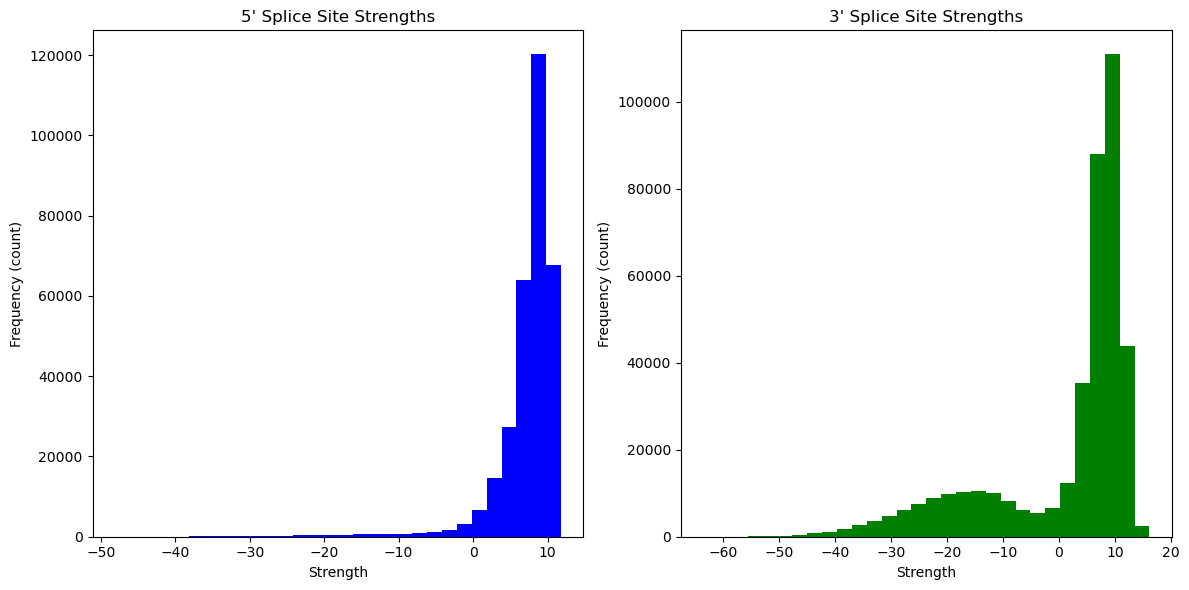

In [9]:
# change to dataframe
# need two seperate DFs because strength arrays are different lengths
FivePrimeDF = pd.DataFrame(spliceSiteStrengths["Five Prime Strengths"], columns = ["Five Prime Strengths"])
ThreePrimeDF = pd.DataFrame(spliceSiteStrengths["Three Prime Strengths"], columns = ["Three Prime Strengths"])

# plot histograms with strength vs. count for 5' and 3' sites
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(FivePrimeDF["Five Prime Strengths"], bins = 30, color='blue')
plt.title('5\' Splice Site Strengths')
plt.xlabel('Strength')
plt.ylabel('Frequency (count)')

plt.subplot(1, 2, 2)
plt.hist(ThreePrimeDF["Three Prime Strengths"], bins = 30, color='green')
plt.title('3\' Splice Site Strengths')
plt.xlabel('Strength')
plt.ylabel('Frequency (count)')

plt.tight_layout()
plt.savefig("./plots/Splice Site Strengths")